# Comparing the spectrum of different graphs

Assume we have a graph with $N$ nodes $(0\ldots N-1)$ and undirected, unweighted edges between those notes. Then the **Adjacency Matrix** $A$ of a graph is defined as the matrix where for every pair of nodes $(i,j)$ that are connected by an edge, $A_{ij}=A_{ji}=1$, and all other nodes are zero. The **Laplace Matrix** $L$ is similar, except that $L_{ij}=L_{ji}=-1$ and the diagonal elements are chosen such that the sum of coefficient over all the rows is zero. The Laplace matrix defines a quadratic form over the space of functions on the nodes, the latter space being represented as the standard vector space $R^N$. Explicitly, for a function (or, vector) $(x_i)$ we define the Laplacian quadratic form as
$$
L_{xx} = \sum_{\mathrm{edges} (i,j)} (x_i - x_j)^2
$$
ie it is the sum of the squared differences of the function values, summed over all edges of the graph.

It is easy to see that there is (at least) one null-vector, the constant vector $(1,1,\ldots)$. It is easy to see that the dimension of the null-space is equal to the disconnected parts of the graph: any vector that is unity on a part and zero elsewhere is a null vector.

Below we will look at a number of different *fundamental* graph topologies:

- **solid** topologies where everyone is linked with everyone else

- **next neighbour** topologies where nodes are arranged according to a geometric object (a line or a circle in one dimension; a flat surface, or the surface of a cylinder or a torus in two dimension) and only nearest neigbours are linked (or possibly 2nd, 3rd neighbours etc also, but with the connection width significantly smaller than the width of the grid

- **star** topologies where one node is linked to an entire group of peripheral nodes that are not connected amongst themselves

We also look at *composite* topologies where a number of the fundamental topologies are combined in a graph. For example, we can have several segments of the graph that within themselves are solidly connected, but that are disjoint, or only a few *next neighbour* links, are that are peripheral nodes in a star topology. We also look at *random* topologies where a certain percentage of the links is dropped.

The key findings from the analysis we ran below are the following:

- every **connected graph** has exactly one zero eigenvalue

- in a connected **solid graph**, all eigenvalues (apart from the zero one) are the same; the value is the number of nodes in the graph, which is equal to one plus the maximal (and average, in this case) number of edges per node

- in a connected **star graph**, there is one very large eigenvalue, and all other eigenvalues (apart from the zero one) are the same and comparatively small; the largest eigenvalue is equal to the number of nodes in the graph, which is equal to one plus the number of edges in the central node; the small eigenvalues are equal to unity

- in a **next neighbour** the is a continous increase in eigenvalues without apparent gaps; usually all eigenvalues are different, unless there are symmetries (eg, rotation for circle and torus based grids); the further reaching the connections the more the eigenvalue "line" is curved, slowly approaching the **solid graph** line; the size of the largest eigenvalue is not clear: it tends to be *bigger* than the maximal number of edges on a node plus one, and it also depends on the topology (eg a second-neighbor linear graph has a smaller eigenvalue than a grid-graph, $7.6$ vs $6.2$, even though both graphs have a maximum and asymptotically average number of edges of $4$)

- in a **probabilistic (solid) graph** the spectrum becomes similar to that of a next neigbour graph; the average eigenvalue seems to be around the average number of edges per node, and conjecture is that the maximum eigenvalue is the maximum number of connections per node plus one

- a **combination graph** usually looks like the *sum of its parts*. For example, to disjoint solid graphs will have a piecewise flat spectrum, or the combination of a linear graph and star graphs will have a gently sloping spectrum with a spike for each of the stars 



## Library functions
see Notebook `Library-General` (those functions should really be in a module, but then this notebook would not be self-sufficient)

In [85]:
import numpy as np
class GraphMatrix:
    """ 
    class to manage and create graph matrices
    the constructor takes the dimension of the matrix
    """
    
    version = "2.0"
        
    def __init__(self, dimension):
        self.array = np.zeros((dimension,dimension))
        self.dim = dimension
        
    def link (self, lfrom, lto, symmetric=True, weight=1.0):
        """
        creates a link from index lfrom to index lto 
        if symmetric == True (default) the also a backlink is created
        depending on self.laplace the diagonal is also adusted
        """
        self.array[lfrom,lto] -= weight;
        self.array[lfrom,lfrom] += weight
        if symmetric: 
            self.array[lto,lfrom] -= weight
            self.array[lto,lto] += weight
        return self.array
    
    def lapl(self):
        """
        returns the Laplace matrix associated to the graph
        """
        return self.array
    
    def adj(self):
        """
        return the adjacancy matrix associated to the graph
        """
        adj = 1 * self.array
        for ix in range(0,self.dim):
            adj[ix][ix] = 0
        return -adj
        
    def d(self):
        """
        returns the dimension of the matrix (as known by the object; not checked if modified!)
        """
        return self.dim;
    
    def printl(self):
        """
        print all the links in the matrix
        """
        links = 0
        for ix1 in range(0,self.dim):
            for ix2 in range(0,self.dim):
                if self.array[ix1][ix2] < 0:
                    print ("%i - %i" % (ix1, ix2))
                    links += 1
        maxlinks = self.dim*(self.dim-1)
        print ("%i links (out of %i; ratio %f)" % (links, self.dim*(self.dim-1), (1.0*links)/maxlinks))

In [86]:
from random import random

def starGraph(GM, ix_center=None, ix_start=None, ix_end = None, weight=1, symmetric=True):
    """
    creates links in the matrix graph GM that have a star topology
    (if GM is an integer the matrix GM is newly created)
    ix_center - the node at center of the star (default: 0)
    ix_start - the start of the star 'spike' nodes (default: center + 1)
    ix_end - the end of the star 'spike' nodes (default: last node in graph)
    returns GM
    """
    if type(GM) == int: GM = GraphMatrix(GM)
    if ix_center == None: ix_center = 0
    if ix_start == None: ix_start = ix_center + 1
    if ix_end == None: ix_end = GM.d()
    
    for ix in range(ix_start,ix_end):
        GM.link(ix_center,ix,symmetric=symmetric, weight=weight)
    return GM

def starGraph1(GM, ix_center=None, ix_start=None, ix_end = None, proba=1.0, weight=1, symmetric=True):
    """
    creates links in the matrix graph GM that have a star topology
    any link however is only created with a probability of `proba`
    (if GM is an integer the matrix GM is newly created)
    ix_center - the node at center of the star (default: 0)
    ix_start - the start of the star 'spike' nodes (default: center + 1)
    ix_end - the end of the star 'spike' nodes (default: last node in graph)
    returns GM
    """
    if type(GM) == int: GM = GraphMatrix(GM)
    if ix_center == None: ix_center = 0
    if ix_start == None: ix_start = ix_center + 1
    if ix_end == None: ix_end = GM.d()
    
    for ix in range(ix_start,ix_end):
        if (random()<=proba): GM.link(ix_center,ix,symmetric=symmetric, weight=weight)
    return GM

def linearGraph(GM, ix_start=None, ix_end = None, circular=False, weight=1, symmetric=True):
    """
    creates links in the matrix graph GM that have a linear (or circular) topology
    (if GM is an integer the matrix GM is newly created)
    ix_start - the start of the linear nodes (default: 0)
    ix_end - the end of the linear nodes (default: last node in graph)
    returns GM
    """
    if type(GM) == int: GM = GraphMatrix(GM)
    if ix_start == None: ix_start = 0
    if ix_end == None: ix_end = GM.d()
    
    for ix in range(ix_start,ix_end-1):
        GM.link(ix,ix+1,symmetric=symmetric, weight=weight)
    if circular: GM.link(ix_end-1,ix_start,symmetric=symmetric, weight=weight)
    return GM

def linearGraph1(GM, ix_start=None, ix_end = None, distance=1, weight=1, symmetric=True):
    """
    creates links in the matrix graph GM that have a linear topology
    (if GM is an integer the matrix GM is newly created)
    ix_start - the start of the linear nodes (default: 0)
    ix_end - the end of the linear nodes (default: last node in graph)
    distance - how far links will be created
    returns GM
    """
    if type(GM) == int: GM = GraphMatrix(GM)
    if ix_start == None: ix_start = 0
    if ix_end == None: ix_end = GM.d()
    
    for dist in range(1,distance+1):
        for ix in range(ix_start,ix_end-dist):
            GM.link(ix,ix+dist,symmetric=symmetric, weight=weight)
    return GM

def solidGraph(GM, ix_start=None, ix_end = None, weight=1):
    """
    creates links in the matrix graph GM that have a solid topology (everyone linked to everyone)
    (if GM is an integer the matrix GM is newly created)
    ix_start - the start of the solid nodes (default: 0)
    ix_end - the end of the solid nodes (default: last node in graph)
    returns GM
    """
    if type(GM) == int: GM = GraphMatrix(GM)
    if ix_start == None: ix_start = 0
    if ix_end == None: ix_end = GM.d()
    
    for ix in range(ix_start,ix_end):
        for ix2 in range (ix_start, ix_end):
            GM.link(ix,ix2, symmetric=False, weight=weight)
    return GM

def solidGraph1(GM, ix_start=None, ix_end = None, proba=1.0, weight=1):
    """
    creates links in the matrix graph GM that have a solid topology (everyone linked to everyone)
    any link however is only created with a probability of `proba`
    (if GM is an integer the matrix GM is newly created)
    ix_start - the start of the solid nodes (default: 0)
    ix_end - the end of the solid nodes (default: last node in graph)
    returns GM
    """
    if type(GM) == int: GM = GraphMatrix(GM)
    if ix_start == None: ix_start = 0
    if ix_end == None: ix_end = GM.d()
    
    for ix in range(ix_start,ix_end):
        for ix2 in range (ix+1, ix_end):
            if (random()<=proba): GM.link(ix,ix2, weight=weight)
    return GM

def gridGraph(GM=None, d1=None, d2=None, circular1=False, circular2=False, ix_start=None, weight=1):
    """
    creates links in the matrix graph GM that have a 2D-grid topology (everyone linked to next neighbor)
    (if GM is None then matrix GM is newly created based on d1, d2, and ix_start)
    d1,d2 are the number of nodes in the two dimensions of the grid
    circular1, circular2 are indicators whether grid are wrapped around at the respective boundary
    ix_start - the start of the solid nodes (default: 0)
    returns GM
    """
    if d1 == None: d1=1
    if d2 == None: d2=1
    if ix_start == None: ix_start=0
    if GM == None: GM = GraphMatrix(ix_start + d1*d2)

    for ix2 in range(0,d2):
        for ix1 in range(0,d1):
            ix = ix_start + ix2*d1 + ix1
            if ix1 < d1-1: GM.link(ix,ix+1, symmetric=True, weight=weight)
            else: 
                if circular1: GM.link(ix,ix_start+ix2*d1, symmetric=True, weight=weight)
            if ix2 < d2-1: GM.link(ix,ix+d1, symmetric=True, weight=weight) 
            else: 
                if circular2: GM.link(ix,ix_start+ix1, symmetric=True, weight=weight)
    return GM

In [87]:
import numpy as np
import matplotlib.pyplot as plt

class EigenSystem:
    """
    collection of tools to deal with eigensystems (eigenvectors and assoviated values)
    """
    
    version = "1.0"
    
    def __init__ (self, matrix, sort=True):
        """
        evals, evecs - the eigensystem
        evecs_in_cols - true iff the vectors are in the columns of the matrix (NumPy default)
        sort - if True, the eigensystem will be sorted
        """
        if not type(matrix) == numpy.ndarray: matrix = matrix.array
        evals, evecs = np.linalg.eig(matrix)
        evecs = evecs.T
        if sort: evals, evecs = self._sort(evals, evecs, evecs_in_cols=False)
        self._evals = evals
        self._evecs = evecs # we like the vectors in the rows
        return
    
    def evals(self):
        """
        accessor: eigenvalues
        """
        return self._evals
    
    def evecs(self, evecs_in_cols=False):
        """
        accessor: eigenvectors
        """
        if evecs_in_cols: return self._evecs.T
        else: return self._evecs
        
    def evec(self, ix, d=None):
        """
        returns one eigenvector
        if d == (d1,d2) the coeffs are put into a matrix d1, d2
        """
        if d == None: return self._evecs[ix]
        
        vec = self._evecs[ix]
        d1 = d[0];
        d2 = d[1];
        ixix = 0;
        result = np.zeros((d2,d1)) # (cols, rows)
        for ix2 in range(0,d2):
            for ix1 in range(0,d1):
                result[ix2][ix1] = vec[ixix] # [col][row]
                ixix += 1
        return result
    
    def d(self):
        return len(self._evals)
    
    def _sort(self, evals=None, evecs=None, reverse=True, evecs_in_cols=True):
        """
        takes the eigenvalues and eigenvectors as returned by the numpy.eigen function
        and jointly sort them by size (default: highest first, unless revers is False)
        """
        if evals == None: evals = self.evals
        if evecs == None: evecs = self.evecs
        if evecs_in_cols: evecs = evecs.T
        evals1 = list((i,x) for x,i in enumerate(evals))
        evals1.sort(reverse=reverse)
        evalss = array(list(ev for ev,i in evals1))
        evecss = array(list(evecs[i] for ev,i in evals1))
        return evalss, evecss
    
    def plot1 (self, therange, vals=False, title=None):
        """
        plot eigenvectors on a graph (legend is eigenvalue)
        """
        if vals:
            if title==None: plt.title("Eigenvalues")
            else: plt.title(title)
            plt.plot(self._evals, 'o-')
            plt.show()
        
        for i in therange:
            plt.plot(self._evecs[i],'o-', label="%.2f (#%i)" % (round(self._evals[i],2),i))
    
        if len(therange)>0:
            if title==None: plt.title("Eigenvectors")
            else: plt.title(title)
            plt.legend()
            plt.show()

    def plot2 (self, px=0, py=1):
        """
        plot a projection of the eigenvectors onto a plane
        px,py are the dimension numbers for the projection
        """
        x = []
        y = []
        for v in self._evecs:
            x.append(v[px])
            y.append(v[py])
        plt.plot(x,y,'+')
        plt.title("Graph of Eigenvectors")
        plt.show    
        
    def plot3 (self, ix, d1, d2):
        """
        assume eigenvector corresponds to matrix d1 x d2
        plot each of the segments as one curve
        """
        vec = self.evec(ix, (d1,d2))
        for i,v in enumerate(vec):
            plt.plot(v, 'o-', label = "%i" % i)
        plt.title("Eigenvector #%i (%f)" % (ix, self._evals[ix]))
        plt.legend()
        plt.show()
        return vec

## Pure topologies

### Solid

eigenvalues 30.0, 30.0, ... , 0.0


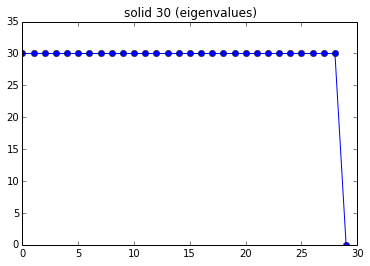

In [88]:
gm = solidGraph(30)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="solid 30 (eigenvalues)")

eigenvalues 30.0, 29.9, ... , -0.0


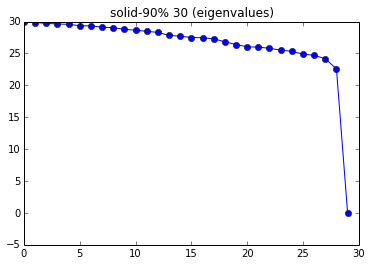

In [89]:
gm = solidGraph1(30, proba=0.9)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="solid-90% 30 (eigenvalues)")

eigenvalues 21.7, 21.0, ... , -0.0


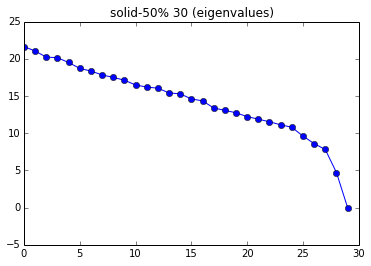

In [90]:
gm = solidGraph1(30, proba=0.5)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="solid-50% 30 (eigenvalues)")

eigenvalues 8.4, 7.6, ... , 0.0


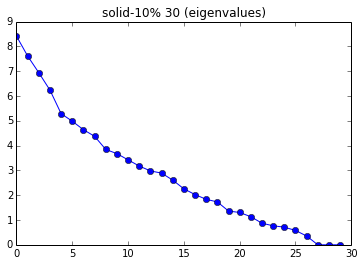

In [91]:
gm = solidGraph1(30, proba=0.1)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="solid-10% 30 (eigenvalues)")

### Star-shaped

eigenvalues 30.0, 1.0, ... , 0.0


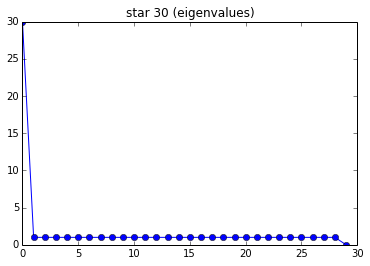

In [92]:
gm = starGraph(30)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="star 30 (eigenvalues)")

### Linear (one dimension)

note that for linear nearest neighbours the maximum and (asymptotically in the non-circular case) average number of connections per node is $2$, in which case the eigenvalue is $4$, ie bigger than $\max+1$ as in the solid case. For distance $2$ we have $4$ connections per node, and max eigenvalue $6.2$, and for distance $3$ we have $6$ connections and $8.6$ 

eigenvalues 4.0, 4.0, ... , 0.0


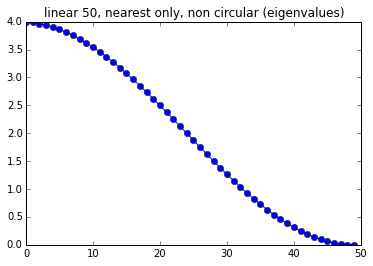

In [93]:
gm = linearGraph(50, circular=False)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="linear 50, nearest only, non circular (eigenvalues)")

eigenvalues 4.0, 4.0, ... , -0.0


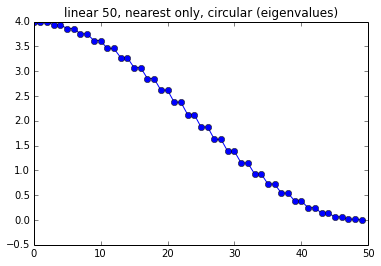

In [94]:
gm = linearGraph(50, circular=True)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="linear 50, nearest only, circular (eigenvalues)")

eigenvalues 6.2, 6.2, ... , 0.0


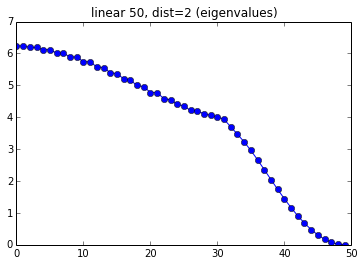

In [95]:
gm = linearGraph1(50, distance=2)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="linear 50, dist=2 (eigenvalues)")

eigenvalues 8.6, 8.6, ... , 0.0


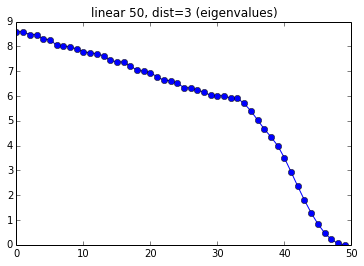

In [96]:
gm = linearGraph1(50, distance=3)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="linear 50, dist=3 (eigenvalues)")

eigenvalues 13.3, 13.3, ... , -0.0


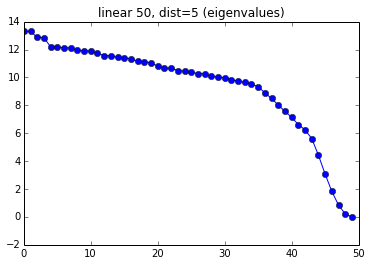

In [97]:
gm = linearGraph1(50, distance=5)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="linear 50, dist=5 (eigenvalues)")

### Grid (two dimensions)

In the two-dimensional grid the maximal and (asymptotically for non-circular) average number of edges per node is $4$. The eigenvalue is $7.7$ (note that this is *higher* than in the above case where 2nd nearest neighbours, which also have $4$ connections, had a value of $6.2$)

eigenvalues 7.7, 7.3, ... , -0.0


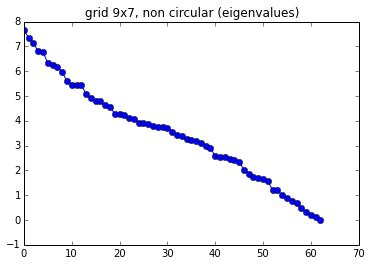

In [98]:
gm = gridGraph(d1=9, d2=7, circular1=False, circular2=False)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="grid 9x7, non circular (eigenvalues)")

eigenvalues 7.7, 7.7, ... , -0.0


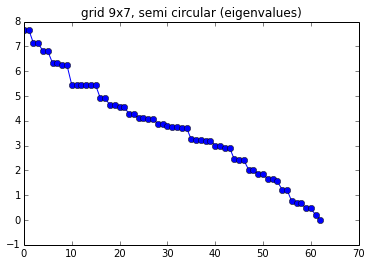

In [99]:
gm = gridGraph(d1=9, d2=7, circular1=True, circular2=False)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="grid 9x7, semi circular (eigenvalues)")

eigenvalues 7.7, 7.7, ... , 0.0


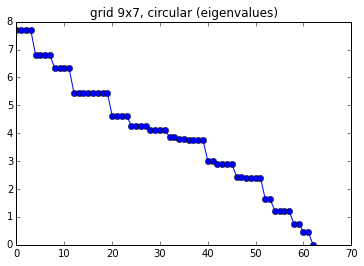

In [100]:
gm = gridGraph(d1=9, d2=7, circular1=True, circular2=True)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="grid 9x7, circular (eigenvalues)")

## Mixed topologies

### Linear, with star overlay

eigenvalues 51.0, 5.0, ... , -0.0


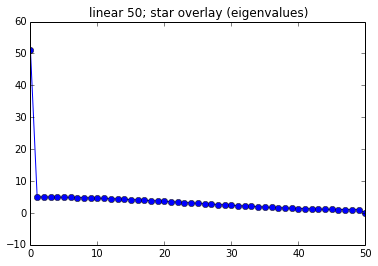

In [101]:
gm = GraphMatrix(51)
linearGraph(gm, ix_start=0, ix_end=50)
starGraph(gm, ix_center=50, ix_start=0, ix_end=50)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="linear 50; star overlay (eigenvalues)")

eigenvalues 11.0, 4.9, ... , 0.0


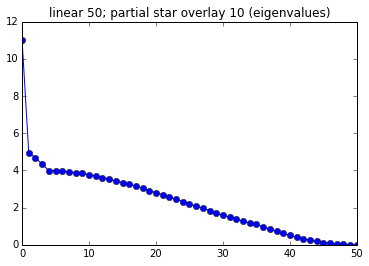

In [102]:
gm = GraphMatrix(51)
linearGraph(gm, ix_start=0, ix_end=50)
starGraph(gm, ix_center=50, ix_start=0, ix_end=10)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="linear 50; partial star overlay 10 (eigenvalues)")

### Solid-solid, no interlinks

eigenvalues 25.0, 25.0, ... , -0.0


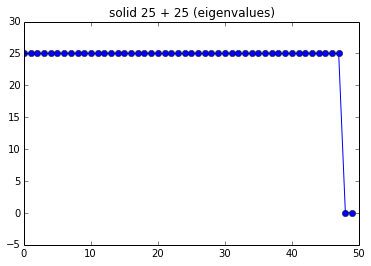

In [103]:
gm = GraphMatrix(50)
solidGraph(gm, ix_start=0, ix_end=25)
solidGraph(gm, ix_start=25, ix_end=50)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="solid 25 + 25 (eigenvalues)")

eigenvalues 40.0, 40.0, ... , -0.0


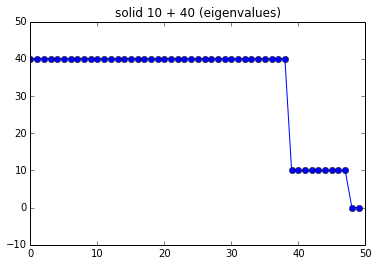

In [104]:
gm = GraphMatrix(50)
solidGraph(gm, ix_start=0, ix_end=10)
solidGraph(gm, ix_start=10, ix_end=50)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="solid 10 + 40 (eigenvalues)")

eigenvalues 30.0, 30.0, ... , -0.0


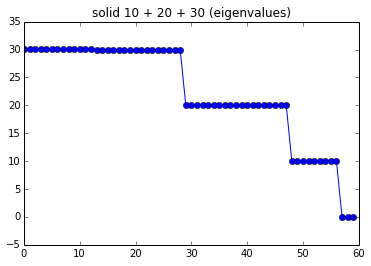

In [105]:
gm = GraphMatrix(60)
solidGraph(gm, ix_start=0, ix_end=10)
solidGraph(gm, ix_start=10, ix_end=30)
solidGraph(gm, ix_start=30, ix_end=60)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="solid 10 + 20 + 30 (eigenvalues)")

### Solid-solid, with interlinks

eigenvalues 26.9, 25.0, ... , -0.0


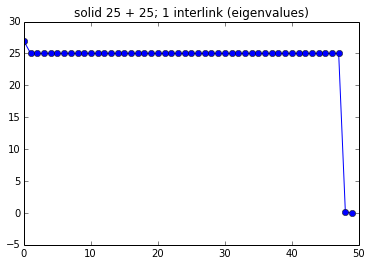

In [106]:
gm = GraphMatrix(50)
solidGraph(gm, ix_start=0, ix_end=25)
solidGraph(gm, ix_start=25, ix_end=50)
for ix in range(0,1):
    gm.link(ix, ix+25)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="solid 25 + 25; 1 interlink (eigenvalues)")

eigenvalues 27.0, 27.0, ... , -0.0


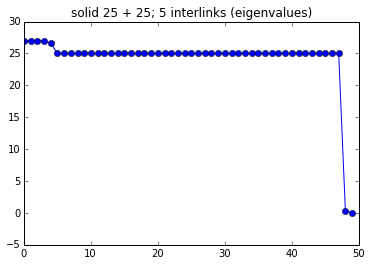

In [107]:
gm = GraphMatrix(50)
solidGraph(gm, ix_start=0, ix_end=25)
solidGraph(gm, ix_start=25, ix_end=50)
for ix in range(0,5):
    gm.link(ix, ix+25)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="solid 25 + 25; 5 interlinks (eigenvalues)")

eigenvalues 27.0, 27.0, ... , -0.0


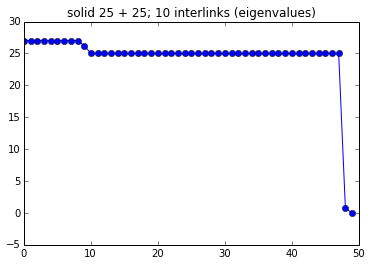

In [108]:
gm = GraphMatrix(50)
solidGraph(gm, ix_start=0, ix_end=25)
solidGraph(gm, ix_start=25, ix_end=50)
for ix in range(0,10):
    gm.link(ix, ix+25)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="solid 25 + 25; 10 interlinks (eigenvalues)")

### Solid-solid, with star overlay

eigenvalues 51.0, 26.0, ... , -0.0


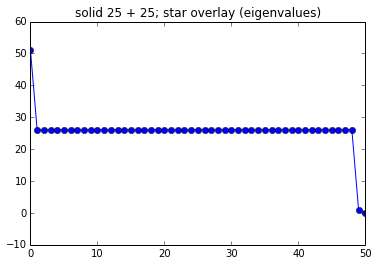

In [109]:
gm = GraphMatrix(51)
solidGraph(gm, ix_start=0, ix_end=25)
solidGraph(gm, ix_start=25, ix_end=50)
starGraph(gm, ix_center=50, ix_start=0, ix_end=50)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="solid 25 + 25; star overlay (eigenvalues)")

eigenvalues 51.0, 31.0, ... , -0.0


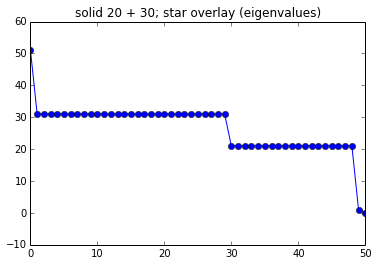

In [110]:
gm = GraphMatrix(51)
solidGraph(gm, ix_start=0, ix_end=20)
solidGraph(gm, ix_start=20, ix_end=50)
starGraph(gm, ix_center=50, ix_start=0, ix_end=50)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="solid 20 + 30; star overlay (eigenvalues)")

### Linear-linear

eigenvalues 4.0, 4.0, ... , -0.0


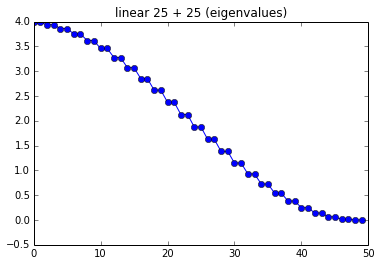

In [111]:
gm = GraphMatrix(50)
linearGraph(gm, ix_start=0, ix_end=25)
linearGraph(gm, ix_start=25, ix_end=50)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="linear 25 + 25 (eigenvalues)")

eigenvalues 4.0, 4.0, ... , -0.0


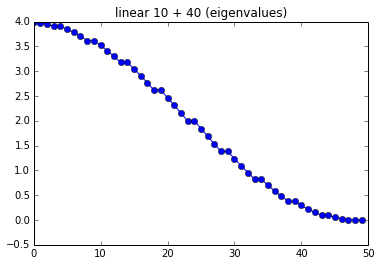

In [112]:
gm = GraphMatrix(50)
linearGraph(gm, ix_start=0, ix_end=10)
linearGraph(gm, ix_start=10, ix_end=50)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="linear 10 + 40 (eigenvalues)")

eigenvalues 12.8, 12.8, ... , 0.0


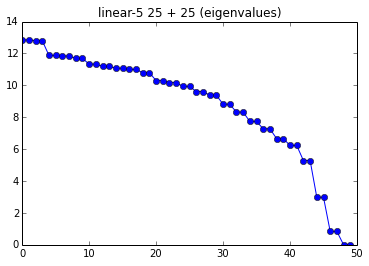

In [113]:
gm = GraphMatrix(50)
linearGraph1(gm, ix_start=0, ix_end=25, distance=5)
linearGraph1(gm, ix_start=25, ix_end=50, distance=5)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="linear-5 25 + 25 (eigenvalues)")

eigenvalues 51.0, 13.8, ... , 0.0


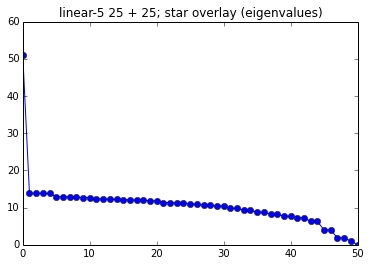

In [114]:
gm = GraphMatrix(51)
linearGraph1(gm, ix_start=0, ix_end=25, distance=5)
linearGraph1(gm, ix_start=25, ix_end=50, distance=5)
starGraph(gm, ix_center=50, ix_start=0, ix_end=50)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="linear-5 25 + 25; star overlay (eigenvalues)")

### Star-star

eigenvalues 25.0, 25.0, ... , 0.0


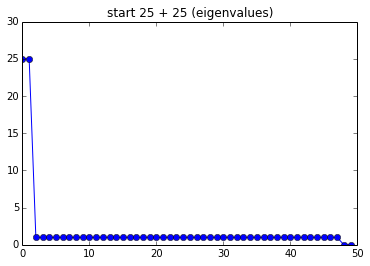

In [115]:
gm = GraphMatrix(50)
starGraph(gm, ix_center=0, ix_start=1, ix_end=25)
starGraph(gm, ix_center=25, ix_start=26, ix_end=50)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="start 25 + 25 (eigenvalues)")

eigenvalues 40.0, 10.0, ... , -0.0


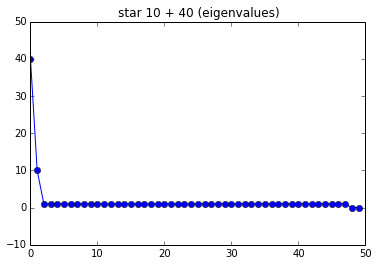

In [116]:
gm = GraphMatrix(50)
starGraph(gm, ix_center=0, ix_start=1, ix_end=10)
starGraph(gm, ix_center=10, ix_start=11, ix_end=50)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="star 10 + 40 (eigenvalues)")

### Grid-grid

eigenvalues 7.7, 7.7, ... , 0.0


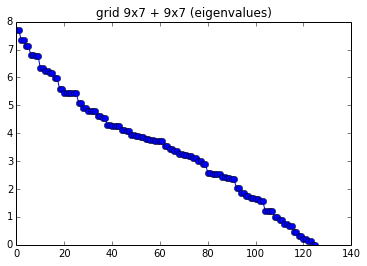

In [117]:
gm = GraphMatrix(63+63)
gm = gridGraph(GM=gm, d1=9, d2=7, ix_start=0,  circular1=False, circular2=False)
gm = gridGraph(GM=gm, d1=9, d2=7, ix_start=63, circular1=False, circular2=False)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="grid 9x7 + 9x7 (eigenvalues)")

## Complex topologies

eigenvalues 59.0, 32.0, ... , -0.0


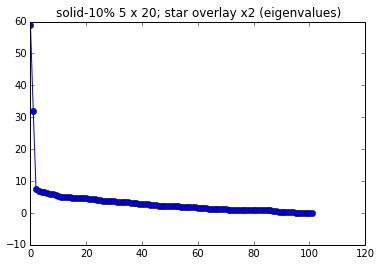

In [118]:
N = 5
w1 = 20
p = .1
ps = 0.5
gm = GraphMatrix(w1*N+2)
for i in range(0,N):
    solidGraph1(gm, ix_start=i*w1, ix_end=(i+1)*w1, proba=p)
starGraph1(gm, ix_center=w1*N,   proba=ps, ix_start=0, ix_end=w1*N)
starGraph1(gm, ix_center=w1*N+1, proba=ps, ix_start=50, ix_end=w1*N)
es = EigenSystem(gm)
print("eigenvalues %2.1f, %2.1f, ... , %2.1f" % (es.evals()[0], es.evals()[1], es.evals()[-1]))
es.plot1((), vals=True, title="solid-%.0f%% %i x %i; star overlay x2 (eigenvalues)" % (p*100,N,w1))